## Feeding

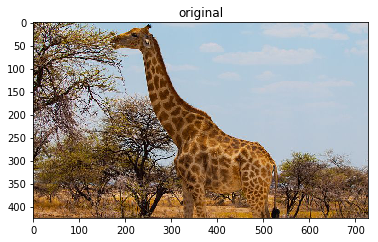

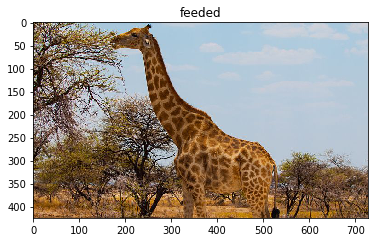

In [2]:
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

images = tf.placeholder(tf.float32, shape=(None,None,3))

data_dir = os.getcwd()+'/data/images'
image_files = [os.path.join(data_dir,f) for f in os.listdir(data_dir) if f.endswith('.jpg')]

with tf.Session() as sess:
    numpy_image = np.array(Image.open(image_files[0]))
    tf_eval_image = sess.run(images,feed_dict={images:numpy_image})
    
    plt.title('original')
    plt.imshow(numpy_image.astype(np.uint8))
    plt.show()
    
    plt.title('feeded')
    plt.imshow(tf_eval_image.astype(np.uint8))
    
    plt.show()

## File reading ops
Image readed directly from files using tensorflow symbolyc ops

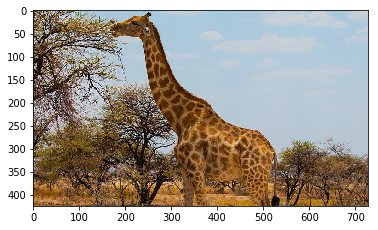

In [3]:
image_files = [os.path.join(data_dir,f) for f in os.listdir(data_dir) if f.endswith('.jpg')]

#create a queue to hold the list of filename to be readed
filename_queue = tf.train.string_input_producer(image_files, shuffle=False)
#create a symbolic op to read the file from disk as sequence of bits
reader = tf.WholeFileReader()
_,file_content = reader.read(filename_queue)
#create a symbolic op to decode data 
image = tf.image.decode_image(file_content)

with tf.Session() as sess:
    #start input reader threads
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    #initialize everything
    sess.run(tf.global_variables_initializer())
    
    #eval image op
    tf_eval_image = sess.run(image)
    plt.imshow(tf_eval_image.astype(np.uint8))
    
    #stop input threads
    coord.request_stop()


## Binary files
Fixed bits length for each sample inside binary files (e.g. cifar10)

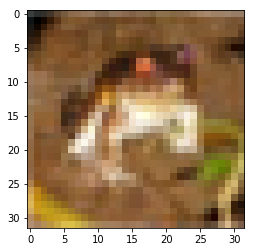

In [4]:
WIDTH=32
HEIGHT=32
DEPTH=3
LABEL_BYTE=1

#dimension of bytes to be readed
label_bytes = LABEL_BYTE  
image_bytes = HEIGHT * WIDTH * DEPTH
record_bytes = label_bytes + image_bytes

#input filenames 
files = ['data/data_batch_1.bin']
filename_queue = tf.train.string_input_producer(files, shuffle=False)

#fixed length record leader
reader = tf.FixedLengthRecordReader(record_bytes=record_bytes)
key, value = reader.read(filename_queue)

#convert bytes to uint with 8 bit precision
record_bytes = tf.decode_raw(value, tf.uint8)

#first byte encodes the label
label = tf.cast(tf.strided_slice(record_bytes, [0], [label_bytes]), tf.int32)
label.set_shape([1])

#the others encode the images
depth_major = tf.reshape( tf.strided_slice(record_bytes, [label_bytes],[label_bytes + image_bytes]), [DEPTH, HEIGHT, WIDTH])
# Convert from [depth, height, width] to [height, width, depth].
uint8image = tf.transpose(depth_major, [1, 2, 0])
image = tf.cast(uint8image, tf.float32)

with tf.Session() as sess:
    #start input reader threads
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    #initialize everything
    sess.run(tf.global_variables_initializer())
    
    #eval image op
    tf_eval_image = sess.run(image)
    plt.imshow(tf_eval_image.astype(np.uint8))
 
    #stop input threads
    coord.request_stop()

## tfrecords
Like binary files but with structure

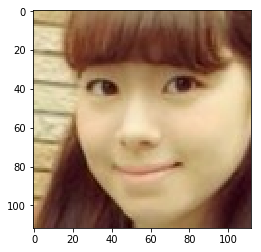

In [5]:
IMAGE_SHAPE = [112,112,3]

#input filenames 
files = ['data/faces/data-00.tfrecords']
filename_queue = tf.train.string_input_producer(files, shuffle=False)


#symbolic reader to read one example at a time
reader = tf.TFRecordReader()
_, serialized_example = reader.read(filename_queue)
features = tf.parse_single_example(
    serialized_example,
    # Defaults are not specified since both keys are required.
    features={
        'image_raw': tf.FixedLenFeature([], tf.string),
        'label': tf.FixedLenFeature([], tf.int64),
    }
)

image = tf.image.decode_jpeg(features['image_raw'], channels=3)
image.set_shape(IMAGE_SHAPE)
label = features['label']

with tf.Session() as sess:
    #start input reader threads
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    #initialize everything
    sess.run(tf.global_variables_initializer())
    
    #eval image op
    tf_eval_image = sess.run(image)
    plt.imshow(tf_eval_image)
    
    #stop input threads
    coord.request_stop()

## Dataset API

New input method for tensorflow

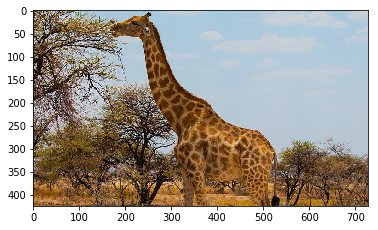

In [19]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def _parse_function(filename):
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_image(image_string)
    image_decoded.set_shape([None,None,3])
    return image_decoded

image_tensor=tf.constant([os.path.join(data_dir,f) for f in os.listdir(data_dir) if f.endswith('.jpg')])

#create the dataset
dataset = tf.contrib.data.Dataset.from_tensor_slices(image_tensor)

#apply parse function operation to each element in image_files and get an image batch
dataset = dataset.map(_parse_function)

#get iterator and image
iterator = dataset.make_one_shot_iterator()
image = iterator.get_next()

with tf.Session() as sess:
    #initialize everything
    sess.run(tf.global_variables_initializer())
    
    #eval image op
    tf_eval_image = sess.run(image)
    plt.imshow(tf_eval_image)